In [113]:
import drdf
import matplotlib.pyplot as plt
import numpy as np

In [114]:
def load_drdf(fname):
  reader = drdf.DRDF()
  reader.read(fname)
  events = []
  for run in reader.runs:
    for event in reader.runs[run]:
      hits_map = dict()
      for cam, img in reader.runs[run][event].items():
        amplitude = img.pixels[:, :, 0] 
        time = img.pixels[:, :, 1]
        hits_map[cam] = amplitude
      events.append((event, hits_map))
  return events

file = load_drdf("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/response.drdf")

In [115]:
def CamList():
    cam_list = []
    for cam in file[0][1]:
        cam_list.append(cam)
    return cam_list

cam_list = CamList()
print(cam_list)

['CAM_NB_X1', 'CAM_NB_X2', 'CAM_NB_X3', 'CAM_NB_X4', 'CAM_NB_X5', 'CAM_NB_X6', 'CAM_NB_X7', 'CAM_NB_X8', 'CAM_NN_Y0', 'CAM_NN_Y1', 'CAM_NN_Y10', 'CAM_NN_Y11', 'CAM_NN_Y12', 'CAM_NN_Y13', 'CAM_NN_Y14', 'CAM_NN_Y15', 'CAM_NN_Y16', 'CAM_NN_Y17', 'CAM_NN_Y18', 'CAM_NN_Y2', 'CAM_NN_Y3', 'CAM_NN_Y4', 'CAM_NN_Y5', 'CAM_NN_Y6', 'CAM_NN_Y7', 'CAM_NN_Y8', 'CAM_NN_Y9', 'CAM_NS_Y0', 'CAM_NS_Y1', 'CAM_NS_Y10', 'CAM_NS_Y11', 'CAM_NS_Y12', 'CAM_NS_Y13', 'CAM_NS_Y14', 'CAM_NS_Y15', 'CAM_NS_Y16', 'CAM_NS_Y17', 'CAM_NS_Y18', 'CAM_NS_Y2', 'CAM_NS_Y3', 'CAM_NS_Y4', 'CAM_NS_Y5', 'CAM_NS_Y6', 'CAM_NS_Y7', 'CAM_NS_Y8', 'CAM_NS_Y9', 'CAM_NT_X1', 'CAM_NT_X2', 'CAM_NT_X3', 'CAM_NT_X4', 'CAM_NT_X5', 'CAM_NT_X6', 'CAM_NT_X7', 'CAM_NT_X8']


In [116]:
def AllImages(): 
    all_images = []
    for i in range(len(file)):
        ph_matrix = []
        for cam in cam_list:
            ph_matrix.append(file[i][1][cam])
        all_images.append(ph_matrix)
    return all_images

all_images = AllImages()

In [ ]:
def PlotCamsImages():
    for i in range(len(all_images)):
        for j in range(len(all_images[i])):
            plt.imshow(all_images[i][j], interpolation='none')
            plt.colorbar()
            plt.title(f"event {file[i][0]} on {cam_list[j]}")
            plt.show()
            break
        break

PlotCamsImages()

for i in range(len(all_images)):
    for j in range(len(all_images[i])):
        if np.any(all_images[i][j] > 10000):
            plt.imshow(all_images[i][j], interpolation='none')
            plt.colorbar()
            plt.title(f"event {file[i][0]} on {cam_list[j]}")
            plt.show()

SCALING DATA

In [117]:
from sklearn.preprocessing import RobustScaler

def ScalingData():
    all_images_scaled = []
    for i in range(len(all_images)):
        ph_matrix_scaled = []
        for j in range(len(all_images[0])):
            transformer = RobustScaler().fit(all_images[i][j])
            scaled_data = transformer.transform(all_images[i][j])
            ph_matrix_scaled.append(scaled_data)
        all_images_scaled.append(ph_matrix_scaled)
    return all_images_scaled

all_images_scaled = ScalingData()


In [118]:
def Flattening():
    all_images_scaled_1d = []
    for sublist in all_images_scaled:
        all_images_scaled_1d.extend(sublist)
    return all_images_scaled_1d

all_images_scaled_1d = Flattening()

In [120]:
def PlotCamsImagesScaled():
    for i in range(len(all_images_scaled)):
        #for cam in cam_list:
        for j in range(len(all_images_scaled[i])):
            plt.imshow(all_images_scaled[i][j], interpolation='none')
            plt.colorbar()
            plt.title(f"scaled event {file[i][0]} on {cam_list[j]}")
            plt.show()
        break 

#PlotCamsImagesScaled()

ROOT

In [121]:
import ROOT as root

#sensor1.root è il file; ogni camera è un TTree
input_file = root.TFile.Open("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/sensors.root", "READ")
tree = input_file.Get("CAM_NB_X1")
entries = tree.GetEntries()

cam_list = CamList()

nr_photons_list_all_cams_list = []
for cam in cam_list:
    nr_photons_list = []
    tree = input_file.Get(cam)
    for i in range(entries):
        n = tree.GetEntry(i)
        inner_photons = tree.innerPhotons
        #if inner_photons: 
        nr_photons_list.append(inner_photons)
    #print(nr_photons_list)
    nr_photons_list_all_cams_list.append(nr_photons_list)

nr_photons_list_all_cams = np.array(nr_photons_list_all_cams_list)#ho creato una matrice 1000 colonne (nr eventi) x 54 righe (nr camere). I numeri che vediamo sono i numeri di fotoni che arrivano alla camera


In [173]:
ev_list_true = []
for i in range(len(file)):
    ev_list_true.append(file[i][0])

In [123]:
def column(matrix, i):
    column = [row[i] for row in matrix]
    return column

all_photons_in_ev = []
for i in ev_list_true:
    nr_photons_in_ev = column(nr_photons_list_all_cams, i)#lista di fotoni in un determinato evento/sono le colonne delle matrici
    all_photons_in_ev.append(nr_photons_in_ev)#faccio una lista di queste liste di fotoni
#print(all_photons_in_ev)

final_root_data = []
for i in range(len(all_photons_in_ev)):
    nr_photon_in_cam = []
    for j in range(len(all_photons_in_ev[i])):
        nr_photon_in_cam.append(all_photons_in_ev[i][j])
    dict_cam_ev = dict(zip(cam_list, nr_photon_in_cam))
    final_root_data.append((ev_list_true[i], dict_cam_ev))
print(final_root_data)

[(0, {'CAM_NB_X1': 0, 'CAM_NB_X2': 0, 'CAM_NB_X3': 0, 'CAM_NB_X4': 0, 'CAM_NB_X5': 0, 'CAM_NB_X6': 0, 'CAM_NB_X7': 0, 'CAM_NB_X8': 0, 'CAM_NN_Y0': 0, 'CAM_NN_Y1': 100, 'CAM_NN_Y10': 0, 'CAM_NN_Y11': 0, 'CAM_NN_Y12': 0, 'CAM_NN_Y13': 301, 'CAM_NN_Y14': 0, 'CAM_NN_Y15': 0, 'CAM_NN_Y16': 337, 'CAM_NN_Y17': 0, 'CAM_NN_Y18': 0, 'CAM_NN_Y2': 0, 'CAM_NN_Y3': 0, 'CAM_NN_Y4': 0, 'CAM_NN_Y5': 0, 'CAM_NN_Y6': 0, 'CAM_NN_Y7': 0, 'CAM_NN_Y8': 0, 'CAM_NN_Y9': 0, 'CAM_NS_Y0': 0, 'CAM_NS_Y1': 0, 'CAM_NS_Y10': 0, 'CAM_NS_Y11': 0, 'CAM_NS_Y12': 0, 'CAM_NS_Y13': 0, 'CAM_NS_Y14': 0, 'CAM_NS_Y15': 0, 'CAM_NS_Y16': 0, 'CAM_NS_Y17': 0, 'CAM_NS_Y18': 0, 'CAM_NS_Y2': 0, 'CAM_NS_Y3': 0, 'CAM_NS_Y4': 0, 'CAM_NS_Y5': 0, 'CAM_NS_Y6': 0, 'CAM_NS_Y7': 0, 'CAM_NS_Y8': 0, 'CAM_NS_Y9': 0, 'CAM_NT_X1': 0, 'CAM_NT_X2': 0, 'CAM_NT_X3': 0, 'CAM_NT_X4': 0, 'CAM_NT_X5': 0, 'CAM_NT_X6': 0, 'CAM_NT_X7': 0, 'CAM_NT_X8': 0}), (1, {'CAM_NB_X1': 0, 'CAM_NB_X2': 0, 'CAM_NB_X3': 0, 'CAM_NB_X4': 0, 'CAM_NB_X5': 0, 'CAM_NB_X6': 0, 'CA

In [177]:
ev_cam_state = []
dict_with_cam_state = final_root_data
for i in range(len(final_root_data)):
    for cam in cam_list:
        if 0 < final_root_data[i][1][cam] <= 5:
            dict_with_cam_state[i][1][cam] = 0
        if final_root_data[i][1][cam] > 5:
            dict_with_cam_state[i][1][cam] = 1
        ev_cam_state.append(dict_with_cam_state[i][1][cam])
print(len(ev_cam_state))

54000


CNN MODEL

In [124]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

In [126]:
# train_ds, val_ds, train_labels, val_labels = train_test_split(all_images_scaled_1d, ev_cam_state, train_size=0.8, random_state=42)

# train_ds = np.array(train_ds)
# val_ds = np.asarray(val_ds)
# train_labels = np.asarray(train_labels) 
# val_labels = np.asarray(val_labels)

t_ds, val_ds, t_labels, val_labels = train_test_split(all_images_scaled_1d, ev_cam_state, train_size=0.9, random_state=42)
train_ds, test_ds, train_labels, test_labels = train_test_split(t_ds, t_labels, train_size=0.9, random_state=42)

train_ds = np.array(train_ds)
val_ds = np.asarray(val_ds)
train_labels = np.asarray(train_labels) 
val_labels = np.asarray(val_labels)
test_ds = np.asarray(test_ds) 
test_labels = np.asarray(test_labels)

In [132]:
input_shape = [32,31,31,1]

train_ds = train_ds.reshape(int(0.9*0.9*len(all_images_scaled_1d)), 31, 31, 1)
val_ds = val_ds.reshape(int(0.1*len(ev_cam_state)), 31, 31, 1)
test_ds = test_ds.reshape(int(0.1*0.9*len(all_images_scaled_1d)),31,31,1)
#np.shape(train_ds)

In [133]:
# model = models.Sequential()
# model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape[1:]))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.Flatten())
# model.add(layers.Dense(1, activation='relu'))

model = models.Sequential()
model.add(layers.MaxPooling2D((31,31), strides=(1,1)))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

In [134]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.build(input_shape=input_shape)

model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_30 (MaxPooli  (32, 1, 1, 1)             0         
 ng2D)                                                           
                                                                 
 flatten_23 (Flatten)        (32, 1)                   0         
                                                                 
 dense_23 (Dense)            (32, 1)                   2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [142]:
epochs = 2
history = model.fit(train_ds, train_labels, validation_data= (val_ds, val_labels), epochs=epochs, batch_size=32)

Epoch 1/2
1367/1367 [==============================] - 1s 535us/step - loss: 0.0000e+00 - accuracy: 0.9862 - val_loss: 0.0000e+00 - val_accuracy: 0.9846
Epoch 2/2
1367/1367 [==============================] - 1s 510us/step - loss: 0.0000e+00 - accuracy: 0.9862 - val_loss: 0.0000e+00 - val_accuracy: 0.9846


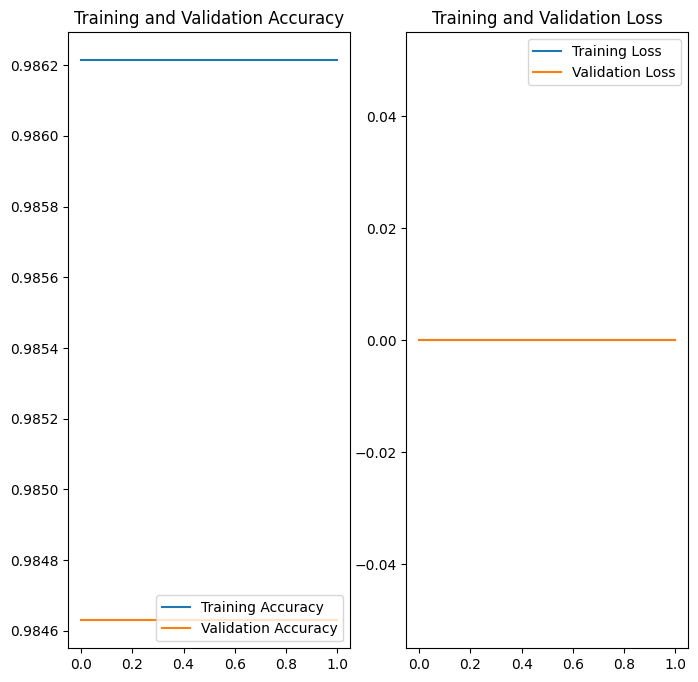

In [143]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [144]:
results = model.evaluate(test_ds,test_labels)
print("test loss, test acc:", results)

152/152 [==============================] - 0s 472us/step - loss: 0.0000e+00 - accuracy: 0.9856
test loss, test acc: [0.0, 0.9855967164039612]
